In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from skimage.metrics import structural_similarity as ssim
from sklearn.model_selection import train_test_split

def display_sample_patches(signal_patches, nonsignal_patches, num_samples=5):
    plt.figure(figsize=(15, 6))

    # Plot a few signal patches
    for i in range(num_samples):
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(signal_patches[i], cmap='gray')
        plt.title(f'Signal {i + 1}')
        plt.axis('off')

    # Plot a few non-signal patches
    for i in range(num_samples):
        plt.subplot(2, num_samples, num_samples + i + 1)
        plt.imshow(nonsignal_patches[i], cmap='gray')
        plt.title(f'Non-Signal {i + 1}')
        plt.axis('off')

    plt.suptitle(f'Sample Image Patches (Signal vs Non-Signal)', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

def train_HO(X, y):
    v_present = X[y == 1]
    v_absent = X[y == 0]
    mean_present = np.mean(v_present, axis=0)
    mean_absent = np.mean(v_absent, axis=0)
    delta_mean = mean_present - mean_absent
    K1 = np.cov(v_absent, rowvar=False)
    K2 = np.cov(v_present, rowvar=False)
    K_avg = 0.5 * (K1 + K2)
    return np.linalg.pinv(K_avg) @ delta_mean

def apply_HO(X, w):
    return X @ w

def compute_SNR_squared(t_score, y):
    t_present = t_score[y == 1]
    t_absent = t_score[y == 0]
    mu1 = np.mean(t_present)
    mu0 = np.mean(t_absent)
    var1 = np.var(t_present, ddof=1)
    var0 = np.var(t_absent, ddof=1)
    sigma2 = 0.5 * (var1 + var0)
    return (mu1 - mu0)**2 / sigma2

def compute_decision_threshold(t_scores, y_labels):
    t_present = t_scores[y_labels == 1]
    t_absent = t_scores[y_labels == 0]
    mu1 = np.mean(t_present)
    mu0 = np.mean(t_absent)
    return 0.5 * (mu1 + mu0)

def generate_gabor_U(size=64, sigmas=[(4, 2)], thetas=[0, 30, 60, 90], freqs=[0.1, 0.15]):
    def create_gabor_channel(size, sigma_x, sigma_y, theta, freq):
        x = np.linspace(-size//2, size//2, size)
        y = np.linspace(-size//2, size//2, size)
        X, Y = np.meshgrid(x, y)
        theta_rad = np.deg2rad(theta)
        X_theta = X * np.cos(theta_rad) + Y * np.sin(theta_rad)
        Y_theta = -X * np.sin(theta_rad) + Y * np.cos(theta_rad)
        gb = np.exp(-0.5 * (X_theta**2 / sigma_x**2 + Y_theta**2 / sigma_y**2)) * np.cos(2 * np.pi * freq * X_theta)
        return gb
    channels = []
    for sigma_x, sigma_y in sigmas:
        for theta in thetas:
            for freq in freqs:
                gabor = create_gabor_channel(size=size, sigma_x=sigma_x, sigma_y=sigma_y, theta=theta, freq=freq)
                channels.append(gabor)
    channels = np.stack(channels)
    U = channels.reshape(channels.shape[0], -1).T
    return U

In [2]:
summary_data = []

# Load the data
img = np.load('Ready_to_train/patches_amp_0.05_noise_0.0004_accel_4.npy', allow_pickle=True).item()
signal_patches = img['signal_patches']
nonsignal_patches = img['nonsignal_patches']
ref_patches = img['reference_patches']

# MSE and SSIM
mse = np.mean([np.mean((a - b) ** 2) for a, b in zip(nonsignal_patches, ref_patches)])
ssim_val = np.mean([ssim(a, b, data_range=1.0) for a, b in zip(nonsignal_patches, ref_patches)])

# Flatten and label
X_signal = np.array([p.flatten() for p in signal_patches])
X_nonsignal = np.array([p.flatten() for p in nonsignal_patches])
X = np.vstack([X_signal, X_nonsignal])
y = np.array([1] * len(X_signal) + [0] * len(X_nonsignal))

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

# === Standard Hotelling Observer
w_ho = train_HO(X_train, y_train)
t_ho_score_test = apply_HO(X_test, w_ho)
t_test_ho = compute_decision_threshold(t_ho_score_test, y_test)
AUC_ho = roc_auc_score(y_test, t_ho_score_test)

# === Channelized Hotelling Observer with different theta counts ===

theta_sets = [[0, 30, 60, 90, 120],[0, 30, 60, 90], [0, 30, 60], [0, 30], [30]]

def generate_gabor_U(size=64, sigmas=[(4, 2)], thetas=[0, 30, 60, 90], freqs=[0.1, 0.15]):
    def create_gabor_channel(size, sigma_x, sigma_y, theta, freq):
        x = np.linspace(-size // 2, size // 2, size)
        y = np.linspace(-size // 2, size // 2, size)
        X, Y = np.meshgrid(x, y)
        theta_rad = np.deg2rad(theta)
        X_theta = X * np.cos(theta_rad) + Y * np.sin(theta_rad)
        Y_theta = -X * np.sin(theta_rad) + Y * np.cos(theta_rad)
        gb = np.exp(-0.5 * (X_theta**2 / sigma_x**2 + Y_theta**2 / sigma_y**2)) * np.cos(2 * np.pi * freq * X_theta)
        return gb

    channels = []
    for sigma_x, sigma_y in sigmas:
        for theta in thetas:
            for freq in freqs:
                gabor = create_gabor_channel(size, sigma_x, sigma_y, theta, freq)
                channels.append(gabor)
    U = np.stack(channels).reshape(len(channels), -1).T
    return U

for thetas in theta_sets:
    U = generate_gabor_U(size=64, sigmas=[(4, 2)], thetas=thetas, freqs=[0.1, 0.15])

    # CHO projection and scoring
    v_train = X_train @ U
    v_test = X_test @ U
    w_cho = train_HO(v_train, y_train)
    t_cho_score_test = apply_HO(v_test, w_cho)
    t_test_cho = compute_decision_threshold(t_cho_score_test, y_test)
    AUC_cho = roc_auc_score(y_test, t_cho_score_test)

    # Save results
    summary_data.append({
        'Filename': 'patches_amp_0.05_noise_0.001_accel_2.npy',
        'Num_Thetas': len(thetas),
        'Num_Channels': U.shape[1],
        'MSE': mse,
        'SSIM': ssim_val,
        'AUC_HO': AUC_ho,
        'AUC_CHO': AUC_cho
    })

In [3]:
import pandas as pd
sd = pd.DataFrame(summary_data)
sd

,Filename,Num_Thetas,Num_Channels,MSE,SSIM,AUC_HO,AUC_CHO
0,patches_amp_0.05_noise_0.001_accel_2.npy,5,10,0.002427,0.645395,0.845517,0.800651
1,patches_amp_0.05_noise_0.001_accel_2.npy,4,8,0.002427,0.645395,0.845517,0.790953
2,patches_amp_0.05_noise_0.001_accel_2.npy,3,6,0.002427,0.645395,0.845517,0.789467
3,patches_amp_0.05_noise_0.001_accel_2.npy,2,4,0.002427,0.645395,0.845517,0.658894
4,patches_amp_0.05_noise_0.001_accel_2.npy,1,2,0.002427,0.645395,0.845517,0.609100


In [4]:
summary_data = []

# Load the data
img = np.load('Ready_to_train/patches_amp_0.05_noise_0.001_accel_2.npy', allow_pickle=True).item()
signal_patches = img['signal_patches']
nonsignal_patches = img['nonsignal_patches']
ref_patches = img['reference_patches']

# MSE and SSIM
mse = np.mean([np.mean((a - b) ** 2) for a, b in zip(nonsignal_patches, ref_patches)])
ssim_val = np.mean([ssim(a, b, data_range=1.0) for a, b in zip(nonsignal_patches, ref_patches)])

# Flatten and label
X_signal = np.array([p.flatten() for p in signal_patches])
X_nonsignal = np.array([p.flatten() for p in nonsignal_patches])
X = np.vstack([X_signal, X_nonsignal])
y = np.array([1] * len(X_signal) + [0] * len(X_nonsignal))

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

# === Standard Hotelling Observer
w_ho = train_HO(X_train, y_train)
t_ho_score_test = apply_HO(X_test, w_ho)
t_test_ho = compute_decision_threshold(t_ho_score_test, y_test)
AUC_ho = roc_auc_score(y_test, t_ho_score_test)

# === Channelized Hotelling Observer with different theta counts ===

theta_sets = [[0, -30, -60, -90], [0, -30, -60], [0, -30], [-30]]

def generate_gabor_U(size=64, sigmas=[(4, 2)], thetas=[0, 30, 60, 90], freqs=[0.1, 0.15]):
    def create_gabor_channel(size, sigma_x, sigma_y, theta, freq):
        x = np.linspace(-size // 2, size // 2, size)
        y = np.linspace(-size // 2, size // 2, size)
        X, Y = np.meshgrid(x, y)
        theta_rad = np.deg2rad(theta)
        X_theta = X * np.cos(theta_rad) + Y * np.sin(theta_rad)
        Y_theta = -X * np.sin(theta_rad) + Y * np.cos(theta_rad)
        gb = np.exp(-0.5 * (X_theta**2 / sigma_x**2 + Y_theta**2 / sigma_y**2)) * np.cos(2 * np.pi * freq * X_theta)
        return gb

    channels = []
    for sigma_x, sigma_y in sigmas:
        for theta in thetas:
            for freq in freqs:
                gabor = create_gabor_channel(size, sigma_x, sigma_y, theta, freq)
                channels.append(gabor)
    U = np.stack(channels).reshape(len(channels), -1).T
    return U

for thetas in theta_sets:
    U = generate_gabor_U(size=64, sigmas=[(4, 2)], thetas=thetas, freqs=[0.1, 0.15])

    # CHO projection and scoring
    v_train = X_train @ U
    v_test = X_test @ U
    w_cho = train_HO(v_train, y_train)
    t_cho_score_test = apply_HO(v_test, w_cho)
    t_test_cho = compute_decision_threshold(t_cho_score_test, y_test)
    AUC_cho = roc_auc_score(y_test, t_cho_score_test)

    # Save results
    summary_data.append({
        'Filename': 'patches_amp_0.05_noise_0.001_accel_2.npy',
        'Num_Thetas': len(thetas),
        'Num_Channels': U.shape[1],
        'MSE': mse,
        'SSIM': ssim_val,
        'AUC_HO': AUC_ho,
        'AUC_CHO': AUC_cho
    })

In [5]:
import pandas as pd
sd = pd.DataFrame(summary_data)
sd

,Filename,Num_Thetas,Num_Channels,MSE,SSIM,AUC_HO,AUC_CHO
0,patches_amp_0.05_noise_0.001_accel_2.npy,4,8,0.00261,0.577274,0.889293,0.832720
1,patches_amp_0.05_noise_0.001_accel_2.npy,3,6,0.00261,0.577274,0.889293,0.811878
2,patches_amp_0.05_noise_0.001_accel_2.npy,2,4,0.00261,0.577274,0.889293,0.690947
3,patches_amp_0.05_noise_0.001_accel_2.npy,1,2,0.00261,0.577274,0.889293,0.665548


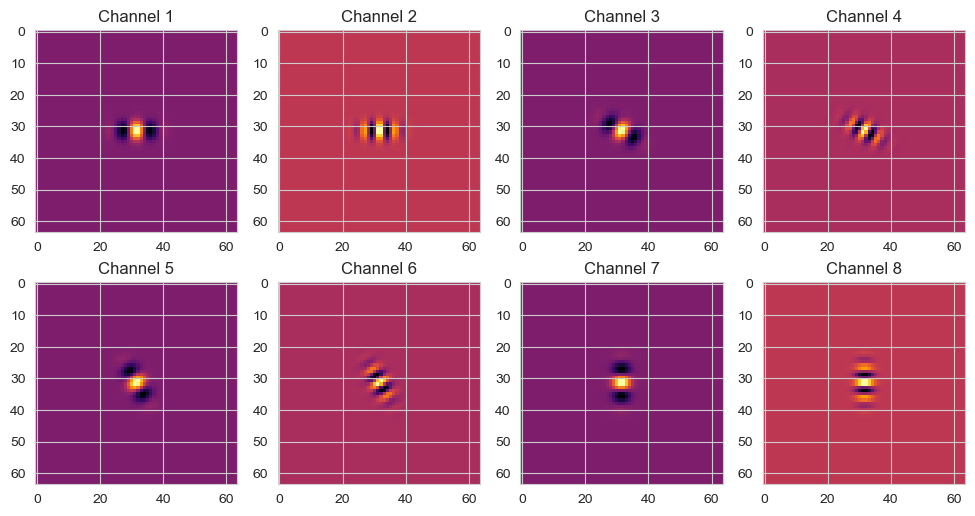

In [6]:
U = generate_gabor_U(size=64, sigmas=[(4, 2)], thetas=[0, 30, 60, 90], freqs=[0.1, 0.2])
plt.figure(figsize=(12, 6))
for i in range(1,len(U.T)+1):
    plt.subplot(2, 4, i)
    plt.imshow(U.T[i-1].reshape(64,64), cmap = 'inferno')
    plt.title(f'Channel {i}')

In [7]:
v_train, v_test = X_train @ U, X_test @ U
print(X_train.shape, v_train.shape)

(19800, 4096) (19800, 8)


In [8]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from skimage.metrics import structural_similarity as ssim

# ------------------ Helper functions ------------------
def train_HO(X, y):
    v_present = X[y == 1]
    v_absent = X[y == 0]
    mean_present = np.mean(v_present, axis=0)
    mean_absent = np.mean(v_absent, axis=0)
    delta_mean = mean_present - mean_absent
    K1 = np.cov(v_absent, rowvar=False)
    K2 = np.cov(v_present, rowvar=False)
    K_avg = 0.5 * (K1 + K2)
    return np.linalg.pinv(K_avg) @ delta_mean

def apply_HO(X, w):
    return X @ w

def compute_decision_threshold(t_scores, y_labels):
    t_present = t_scores[y_labels == 1]
    t_absent = t_scores[y_labels == 0]
    mu1 = np.mean(t_present)
    mu0 = np.mean(t_absent)
    return 0.5 * (mu1 + mu0)

def generate_gabor_U(size=64, sigmas=[(4, 2)], thetas=[0, 30, 60, 90], freqs=[0.1, 0.15]):
    def create_gabor_channel(size, sigma_x, sigma_y, theta, freq):
        x = np.linspace(-size // 2, size // 2, size)
        y = np.linspace(-size // 2, size // 2, size)
        X, Y = np.meshgrid(x, y)
        theta_rad = np.deg2rad(theta)
        X_theta = X * np.cos(theta_rad) + Y * np.sin(theta_rad)
        Y_theta = -X * np.sin(theta_rad) + Y * np.cos(theta_rad)
        gb = np.exp(-0.5 * (X_theta**2 / sigma_x**2 + Y_theta**2 / sigma_y**2)) * np.cos(2 * np.pi * freq * X_theta)
        return gb
    channels = []
    for sigma_x, sigma_y in sigmas:
        for theta in thetas:
            for freq in freqs:
                gabor = create_gabor_channel(size, sigma_x, sigma_y, theta, freq)
                channels.append(gabor)
    return np.stack(channels).reshape(len(channels), -1).T

# ------------------ Load and prepare data ------------------
file_path = "Ready_to_train/patches_amp_0.05_noise_0.001_accel_2.npy"
img = np.load(file_path, allow_pickle=True).item()
signal_patches = img['signal_patches']
nonsignal_patches = img['nonsignal_patches']
ref_patches = img['reference_patches']

# Image quality metrics
mse = np.mean([np.mean((a - b) ** 2) for a, b in zip(nonsignal_patches, ref_patches)])
ssim_val = np.mean([ssim(a, b, data_range=1.0) for a, b in zip(nonsignal_patches, ref_patches)])

# Flatten and label
X_signal = np.array([p.flatten() for p in signal_patches])
X_nonsignal = np.array([p.flatten() for p in nonsignal_patches])
X = np.vstack([X_signal, X_nonsignal])
y = np.array([1] * len(X_signal) + [0] * len(X_nonsignal))

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

# ------------------ HO baseline ------------------
w_ho = train_HO(X_train, y_train)
t_ho_score_test = apply_HO(X_test, w_ho)
t_test_ho = compute_decision_threshold(t_ho_score_test, y_test)
AUC_ho = roc_auc_score(y_test, t_ho_score_test)

# ------------------ Parameter sets ------------------
theta_sets = [[30], [0, 30], [0, 30, 60], [0, 30, 60, 90], [0, 30, 60, 90, 120]]
freq_sets = [[0.05], [0.05, 0.1], [0.05, 0.1, 0.15], [0.05, 0.1, 0.15, 0.2], [0.05, 0.1, 0.15, 0.2, 0.25]]
sigma_sets_y = [[(4, 2)], [(4, 4)], [(4, 6)], [(4, 8)], [(4, 10)]]
sigma_sets_x = [[(2, 2)], [(4, 2)], [(6, 2)], [(8, 2)], [(10, 2)]]

summary_data = []

# ------------------ Run experiments ------------------
# 1. Vary theta
for thetas in theta_sets:
    U = generate_gabor_U(sigmas=[(4, 2)], thetas=thetas, freqs=[0.1, 0.15])
    v_train, v_test = X_train @ U, X_test @ U
    w_cho = train_HO(v_train, y_train)
    t_cho_score_test = apply_HO(v_test, w_cho)
    AUC_cho = roc_auc_score(y_test, t_cho_score_test)
    summary_data.append({'Variation': 'Theta', 'Param': str(thetas), 'Num_Channels': U.shape[1],
                         'MSE': mse, 'SSIM': ssim_val, 'AUC_HO': AUC_ho, 'AUC_CHO': AUC_cho})

# 2. Vary frequency
for freqs in freq_sets:
    U = generate_gabor_U(sigmas=[(4, 2)], thetas=[0, 30, 60, 90], freqs=freqs)
    v_train, v_test = X_train @ U, X_test @ U
    w_cho = train_HO(v_train, y_train)
    t_cho_score_test = apply_HO(v_test, w_cho)
    AUC_cho = roc_auc_score(y_test, t_cho_score_test)
    summary_data.append({'Variation': 'Frequency', 'Param': str(freqs), 'Num_Channels': U.shape[1],
                         'MSE': mse, 'SSIM': ssim_val, 'AUC_HO': AUC_ho, 'AUC_CHO': AUC_cho})

# 3. Vary sigma_y (keeping sigma_x = 4)
for sigmas in sigma_sets_y:
    U = generate_gabor_U(sigmas=sigmas, thetas=[0, 30, 60, 90], freqs=[0.1, 0.15])
    v_train, v_test = X_train @ U, X_test @ U
    w_cho = train_HO(v_train, y_train)
    t_cho_score_test = apply_HO(v_test, w_cho)
    AUC_cho = roc_auc_score(y_test, t_cho_score_test)
    summary_data.append({'Variation': 'SigmaY', 'Param': str(sigmas), 'Num_Channels': U.shape[1],
                         'MSE': mse, 'SSIM': ssim_val, 'AUC_HO': AUC_ho, 'AUC_CHO': AUC_cho})

# 4. Vary sigma_x (keeping sigma_y = 2)
for sigmas in sigma_sets_x:
    U = generate_gabor_U(sigmas=sigmas, thetas=[0, 30, 60, 90], freqs=[0.1, 0.15])
    v_train, v_test = X_train @ U, X_test @ U
    w_cho = train_HO(v_train, y_train)
    t_cho_score_test = apply_HO(v_test, w_cho)
    AUC_cho = roc_auc_score(y_test, t_cho_score_test)
    summary_data.append({'Variation': 'SigmaX', 'Param': str(sigmas), 'Num_Channels': U.shape[1],
                         'MSE': mse, 'SSIM': ssim_val, 'AUC_HO': AUC_ho, 'AUC_CHO': AUC_cho})


In [9]:
# ------------------ Final output ------------------
summary_df = pd.DataFrame(summary_data)

# Print shared MSE and SSIM values
mse_val = summary_df['MSE'].iloc[0]
ssim_val = summary_df['SSIM'].iloc[0]
print(f"MSE (all experiments): {mse_val:.4f}")
print(f"SSIM (all experiments): {ssim_val:.4f}")

# Display table without MSE and SSIM
print(summary_df.drop(columns=['MSE', 'SSIM']))

MSE (all experiments): 0.0026
SSIM (all experiments): 0.5773
    Variation                         Param  Num_Channels    AUC_HO   AUC_CHO
0       Theta                          [30]             2  0.889293  0.759735
1       Theta                       [0, 30]             4  0.889293  0.797885
2       Theta                   [0, 30, 60]             6  0.889293  0.827893
3       Theta               [0, 30, 60, 90]             8  0.889293  0.833364
4       Theta          [0, 30, 60, 90, 120]            10  0.889293  0.833022
5   Frequency                        [0.05]             4  0.889293  0.560574
6   Frequency                   [0.05, 0.1]             8  0.889293  0.876299
7   Frequency             [0.05, 0.1, 0.15]            12  0.889293  0.886661
8   Frequency        [0.05, 0.1, 0.15, 0.2]            16  0.889293  0.889026
9   Frequency  [0.05, 0.1, 0.15, 0.2, 0.25]            20  0.889293  0.892455
10     SigmaY                      [(4, 2)]             8  0.889293  0.833364
11 

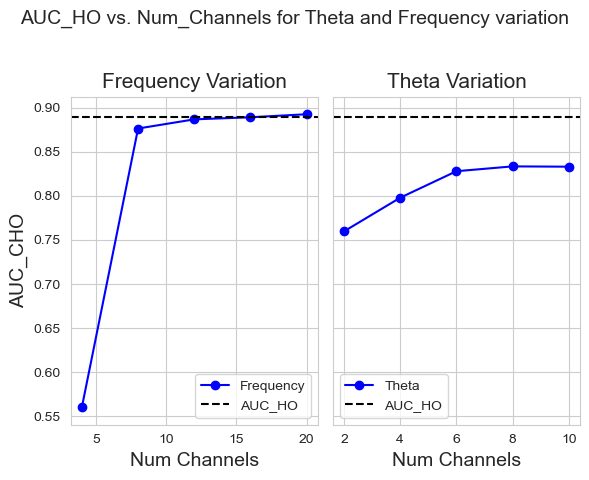

In [24]:
# Filter only Theta and Frequency
filtered_df = summary_df[summary_df['Variation'].isin(['Theta', 'Frequency'])]

# Set up plotting
fig, axs = plt.subplots(1, 2, figsize=(6, 5), sharey=True)

# AUC reference line from first Theta experiment
auc_theta_ref = filtered_df[filtered_df['Variation'] == 'Theta']['AUC_HO'].iloc[0]
ymin = filtered_df['AUC_CHO'].min() - 0.02
ymax = filtered_df['AUC_CHO'].max() + 0.02

# Plot
for i, (variation, group) in enumerate(filtered_df.groupby("Variation")):
    axs[i].plot(group['Num_Channels'], group['AUC_CHO'], marker='o', label=f'{variation}', color = 'blue')
    axs[i].axhline(y=auc_theta_ref, linestyle='--', color='black', label='AUC_HO')
    axs[i].set_title(f"{variation} Variation", fontsize = 15)
    axs[i].set_xlabel("Num Channels", fontsize = 14)
    axs[i].set_ylim([ymin, ymax])
    axs[i].grid(True)
    if i == 0:
        axs[i].set_ylabel("AUC_CHO", fontsize = 14)
    axs[i].legend()

plt.suptitle("AUC_HO vs. Num_Channels for Theta and Frequency variation", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


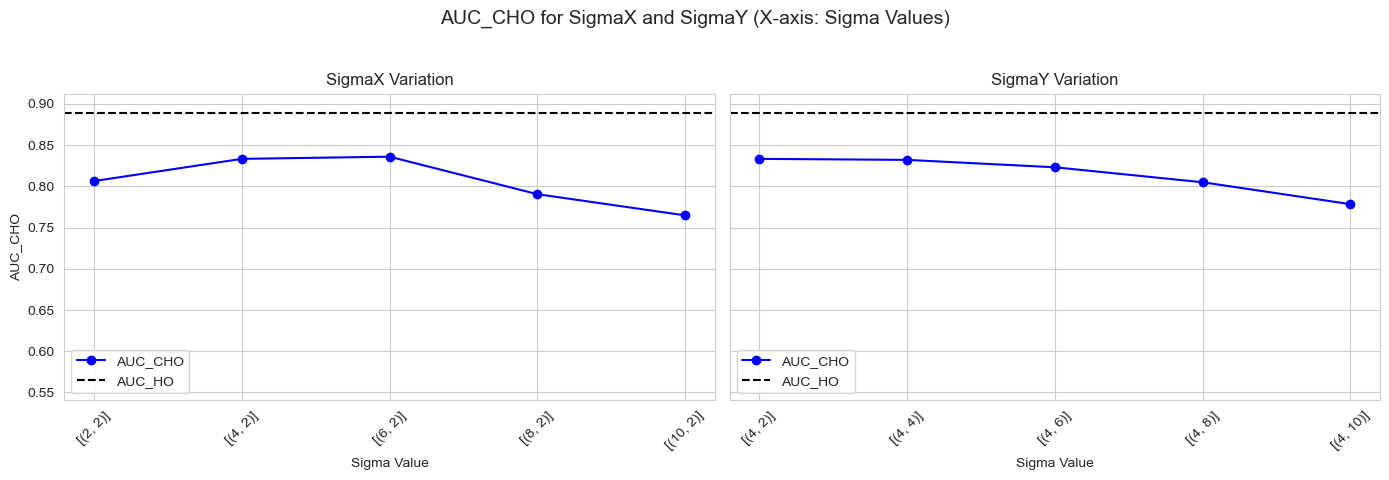

In [13]:
# Add sigma values as labels on the x-axis for SigmaX and SigmaY plots

# Filter only SigmaX and SigmaY
filtered_df = summary_df[summary_df['Variation'].isin(['SigmaX', 'SigmaY'])]

# Set up plotting
fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# AUC reference from first Theta experiment
auc_theta_ref = summary_df[summary_df['Variation'] == 'Theta']['AUC_HO'].iloc[0]
ymin = summary_df['AUC_CHO'].min() - 0.02
ymax = summary_df['AUC_CHO'].max() + 0.02

# Plot
for i, (variation, group) in enumerate(filtered_df.groupby("Variation")):
    group = group.reset_index(drop=True)
    sigma_labels = group['Param'].tolist()  # Assumes Param column stores sigma as text like '(4,2)'
    axs[i].plot(group.index, group['AUC_CHO'], marker='o', label='AUC_CHO', color = 'blue')
    axs[i].axhline(y=auc_theta_ref, linestyle='--', color='black', label='AUC_HO')
    axs[i].set_title(f"{variation} Variation")
    axs[i].set_xlabel("Sigma Value")
    axs[i].set_xticks(group.index)
    axs[i].set_xticklabels(sigma_labels, rotation=45)
    axs[i].set_ylim([ymin, ymax])
    axs[i].grid(True)
    if i == 0:
        axs[i].set_ylabel("AUC_CHO")
    axs[i].legend()

plt.suptitle("AUC_CHO for SigmaX and SigmaY (X-axis: Sigma Values)", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
